<a href="https://colab.research.google.com/github/91htjung/AirportBusinessAnalytics/blob/main/02-Forecast_Shortterm_Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting with Python
Welcome to Airport Business Analytics Course.

In this exercise, we will use Google Colab to run the forecast using Python programming Language.

There are two different exercise, one with a long-term forecast (10 years) using log-log regression model, and the other with a short-term forecast (24 months) using ARIMA model.


1.   01-Forecast_Longterm_Econometric
2.   02-Forecast_Shortterm_Statistics


# In this module you will learn how to:

1.   Interact with Pandas library, reading and transforming the dataset
2.   Split our data into train-test samples
3.   Train an Exponential Smoothing and ARIMA model and test the result
4.   Perform a 24-months forecast using the trained model.


# Setting up the environment

To perform forecasting in Python, we will need to install packages - a collection of Python modules, functions, classes, and variables that can be utilized in other Python programs. Packages provide a structured way to organize and distribute Python code, making it easier for developers to manage and reuse code across different projects.

Here, simply run the cell below by using the keyboard "Ctrl+Enter". The code will be executed and necessary packages will be installed.

In [2]:
# Importing necessary packages to run the cells below
import pandas as pd
import numpy as np
import warnings

try:
    import pmdarima
    import sktime
    import seaborn as sns
except:
    !pip install --root-user-action=ignore -q ../input/aci-airport-business-analytics-doha/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl
    !pip install --root-user-action=ignore -q ../input/aci-airport-business-analytics-doha/scikit_base-0.11.0-py3-none-any.whl
    !pip install --root-user-action=ignore -q ../input/aci-airport-business-analytics-doha/sktime-0.34.0-py3-none-any.whl
    import sktime
    import seaborn as sns

sns.set(rc={'figure.figsize':(12,6)})
warnings.filterwarnings("ignore")

In this exercise, we will use sktime library to perform forecasting.

# Reading data

Let's read a dataset. The dataset can be read by the code below. Similarly, use keyboard "Ctrl+Enter" to run the cell below.

In [3]:
# Reading a CSV file into dataset variable
dataset = pd.read_csv('../input/aci-airport-business-analytics-doha/ABA-DOH-Data_Shortterm_Statistics.csv')


# Parse the Period column into monthly period format and use it as an index of the table
dataset['Period'] = pd.to_datetime(dataset['Period'])
dataset = dataset.set_index(['Period']).to_period("M")
dataset

,Airport A,Airport B
Period,,
2010-01,1297508,1453070
2010-02,1209205,1319609
2010-03,1469505,1433403
2010-04,1378510,1364560
2010-05,1701556,1353164
...,...,...
2022-12,1755963,1660503
2023-01,1761112,1816111
2023-02,1657883,1651736


The dataset is made up with historic monthly Passenger from two dummy airports - Airport A and Airport B.

Our goal is to perform the forecast of passenger, using the historical passenger traffic. (univariate forecasting)

# Visualizing data

A great way to begin our examination of the truth would be to visualize the relationship through a chart. We will use seperate line charts to visualize each variables.

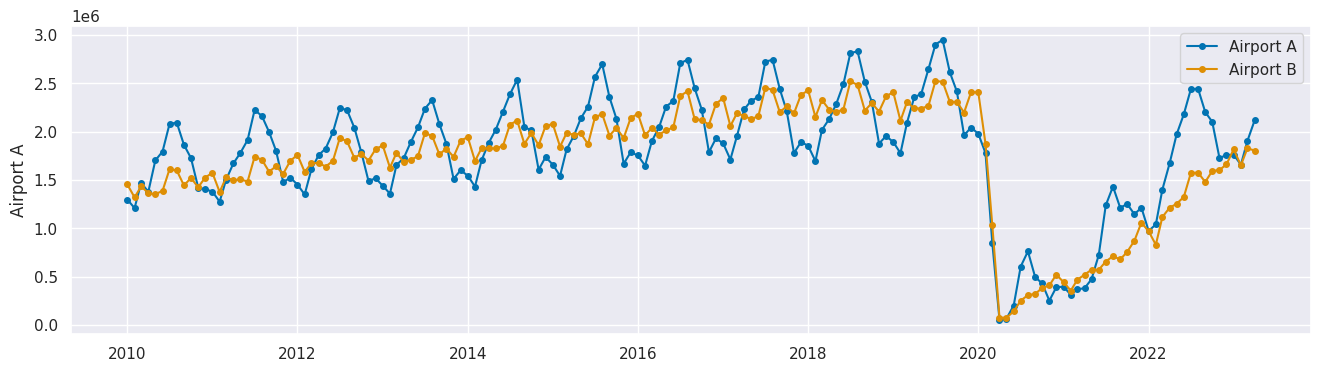

In [4]:
from sktime.utils.plotting import plot_series

# plotting both Airport A and Airport B
plot_series(dataset['Airport A'], dataset['Airport B'], labels=['Airport A', 'Airport B']);

One visible challenge of forecasting is that we have is that the passenger numbers of both Airport A and Aiport B have significantlly reduced in 2020, due to the global COVID-19 pandemic.


The traffic before the COVID-19 pandemic and during the recovery have significantly different patterns.

Therefore, in this exercise, we will first split dataset into two groups:

*   **Before Covid** (2010 January - 2019 December)
*   **After Covid** (2020 January - 2023 April)



In [5]:
# splitting data into two sets, one before covid (where the pattern is stable), and the other after covid.
before_covid = dataset[(dataset.index <= pd.Period('2019-12-01', freq='M'))]
after_covid = dataset[(dataset.index > pd.Period('2019-12-01', freq='M'))]

# Training and test data splitting

Remember that when we are using data-driven techniques, we need to split our sample into a training/test set.

*   **Training set**: subset of the data used to develop models (learn)
*   **Test set**: subset of the data used to test the models (ensure you learned the right thing)

Here, we will assign last 24 data points (2 years) as test set.

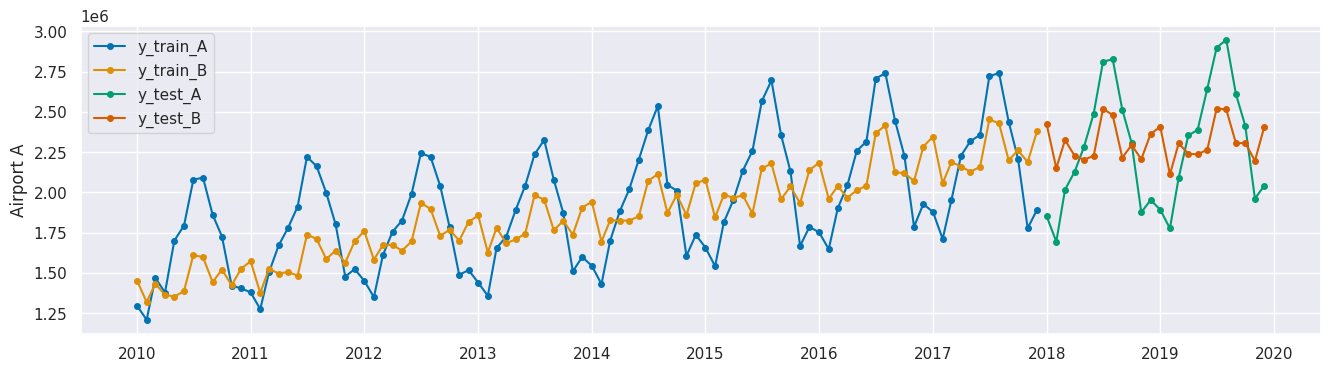

In [6]:
from sktime.forecasting.model_selection import temporal_train_test_split

# Splitting test data from the last 24 months
y_train, y_test = temporal_train_test_split(before_covid, test_size=24)

# Plotting the split train and testing data
plot_series(y_train['Airport A'], y_train['Airport B'], y_test['Airport A'], y_test['Airport B'], labels=['y_train_A', 'y_train_B', 'y_test_A', 'y_test_B']);

# Forecasting horizon

Then, we need to defind forecasting horizon (fh) - the period we will make a prediction using the model.

In this case, our goal is to train a forecasting model with training data (y_train), make a prediction (y_pred), and evaluate with the test data (y_test).

Therefore, the forecasting horizon should be matching with test data (last 24 months).

In [7]:
from sktime.forecasting.base import ForecastingHorizon

# fh(forecasting horizon): the length of time into the future for which forecasts are to be prepared.
fh = ForecastingHorizon(y_test.index, is_relative=False)
print(f"Forecasting Horizon: {fh}")

Forecasting Horizon: ForecastingHorizon(['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
             '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
             '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
             '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12'],
            dtype='period[M]', is_relative=False)


# Training the model

In this example, we will try two different model; **(1) Exponential Smoothing (Holt-Winters), and (2) ARIMA**. The detailed explanation of Exponential Smoothing and ARIMA are in the **Module 8** presentation.

We will run each model and evaluate which model works well for each airport.

Let's run the cell below to start with Exponential Smoothing forecast.

> In the Exponential Smoothing model, we assume that the seasonality is multiplicative with seasonal pattern of 12 months.

In [8]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# holt-winter (triple exponential smoothing) with multiplicative seasonality of 12 data points - monthly
# https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.exp_smoothing.ExponentialSmoothing.html
exp_forecaster = ExponentialSmoothing(seasonal='multiplicative', sp=12).fit(y_train)
y_pred_exp = exp_forecaster.predict(fh=fh)
y_pred_exp

,Airport A,Airport B
2018-01,1.799187e+06,2.402077e+06
2018-02,1.655461e+06,2.110700e+06
2018-03,1.937020e+06,2.259611e+06
2018-04,2.106800e+06,2.211409e+06
2018-05,2.258850e+06,2.203870e+06
2018-06,2.384017e+06,2.210487e+06
2018-07,2.717676e+06,2.527432e+06
2018-08,2.763136e+06,2.505701e+06
2018-09,2.438988e+06,2.244218e+06
2018-10,2.221324e+06,2.312287e+06


Then, we will run the (seasonal) ARIMA model.

> In the ARIMA model, we use parameters with p=1, q=0, d=1, and seasonal parameters P=1, Q=1, D=1, and number of periods m=12.


In [9]:
from sktime.forecasting.arima import ARIMA

# ARIMA model with (1,0,1) order and (1,1,1,12) seasonal order.
# https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.forecasting.arima.ARIMA.html
arima_forecaster = ARIMA(order=(1, 0, 1), seasonal_order=(1, 1, 1, 12)).fit(y_train)
y_pred_arima = arima_forecaster.predict(fh=fh)
y_pred_arima

,Airport A,Airport B
2018-01,1.953365e+06,2.467659e+06
2018-02,1.792356e+06,2.179040e+06
2018-03,2.033917e+06,2.307194e+06
2018-04,2.309925e+06,2.278993e+06
2018-05,2.400368e+06,2.247651e+06
2018-06,2.438854e+06,2.284441e+06
2018-07,2.803531e+06,2.580795e+06
2018-08,2.823852e+06,2.559668e+06
2018-09,2.521753e+06,2.325465e+06
2018-10,2.291536e+06,2.384418e+06


# Compare the results

Now, let's check the result of each airport of two different forecasting models.

The results of Airport A look like below:

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Airport A, ARIMA'}, ylabel='Airport A'>)

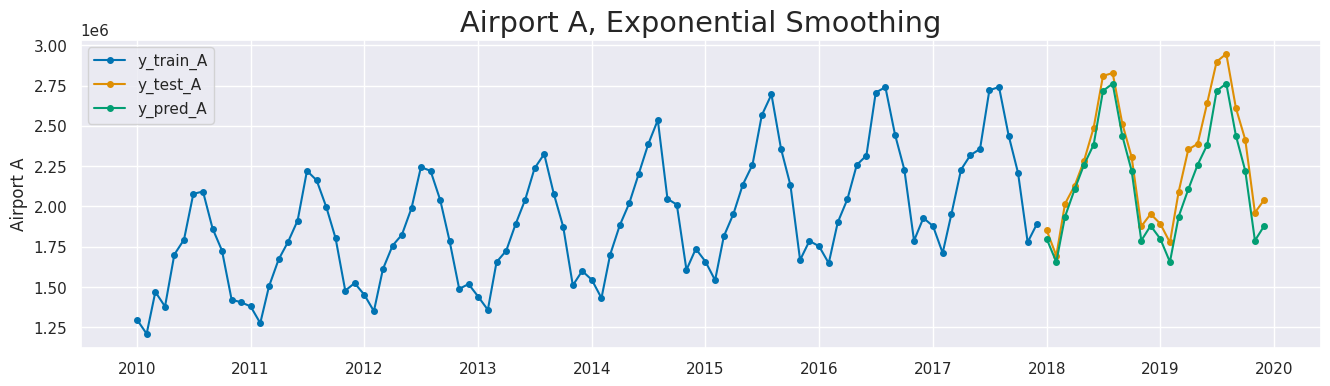

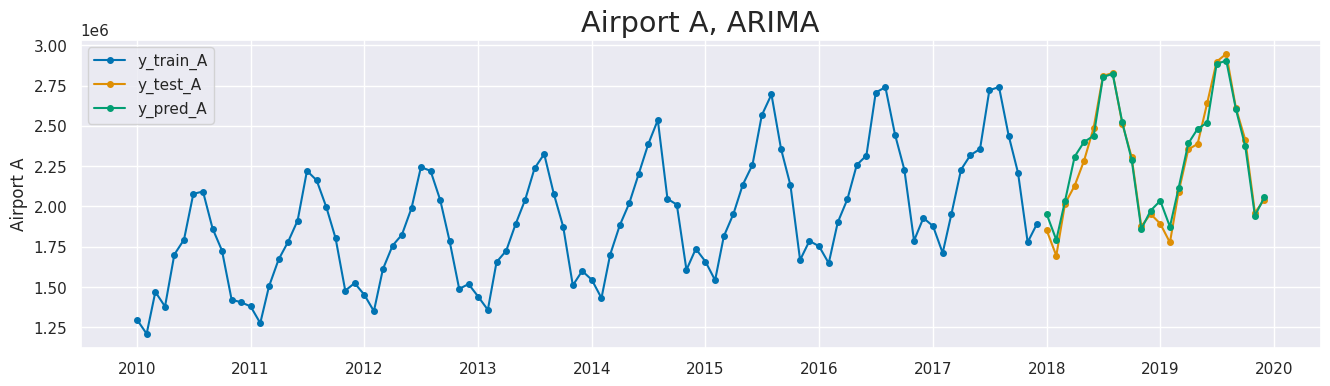

In [10]:
# plotting Exponential Smoothing result of Airport A
plot_series(y_train['Airport A'], y_test['Airport A'], y_pred_exp['Airport A'],
            labels=['y_train_A', 'y_test_A', 'y_pred_A'], title='Airport A, Exponential Smoothing')

# plotting ARIMA result of Airport A
plot_series(y_train['Airport A'], y_test['Airport A'], y_pred_arima['Airport A'],
            labels=['y_train_A', 'y_test_A', 'y_pred_A'], title='Airport A, ARIMA')

Then, we calculate of MAPE of each models:

In [11]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

# Comparing MAPE of Exponential Smoothing predictions vs MAPE of ARIMA predictions, for Airport A
mape = MeanAbsolutePercentageError(symmetric=False)
print('MAPE of Airport A')
print('Exponential Smoothing: %.4f' % mape(y_test['Airport A'], y_pred_exp['Airport A']))
print('ARIMA: %.4f' % mape(y_test['Airport A'], y_pred_arima['Airport A']))

MAPE of Airport A
Exponential Smoothing: 0.0521
ARIMA: 0.0254


For Airport A, the Exponential Smoothing showed 5.21% of MAPE, while the ARIMA showed 2.54% of MAPE.

Here, ARIMA model marked the better accuracy then Exponential Smoothing model.



The results of Airport B look like below:

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Airport B, ARIMA'}, ylabel='Airport B'>)

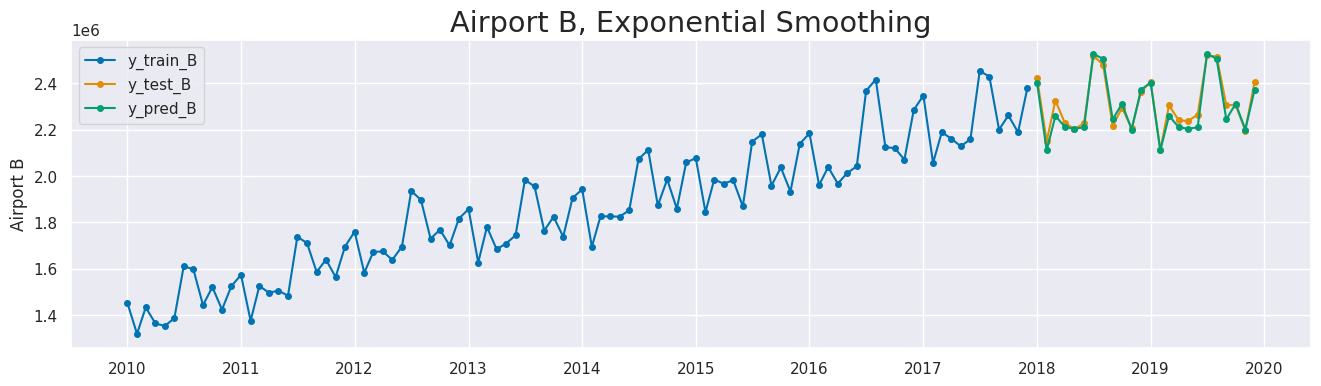

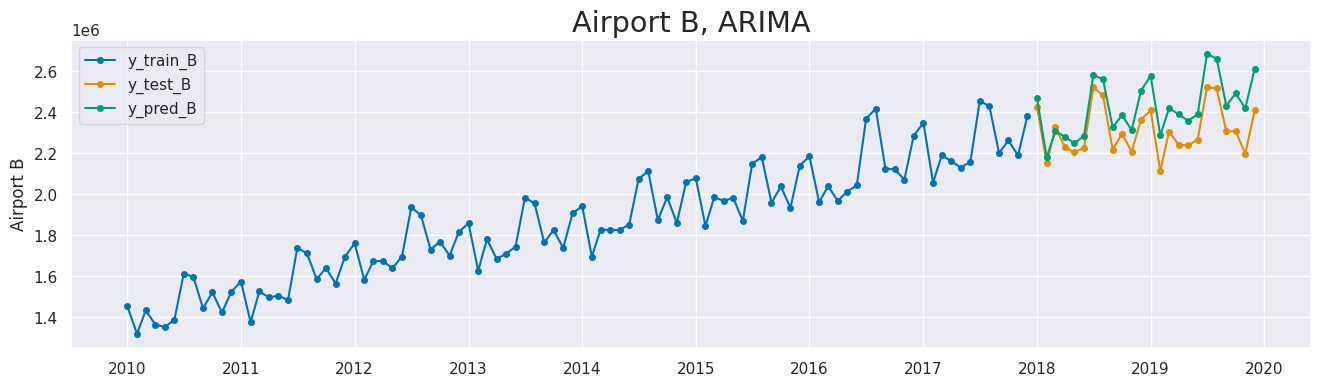

In [12]:
# plotting Exponential Smoothing result of Airport B
plot_series(y_train['Airport B'], y_test['Airport B'], y_pred_exp['Airport B'],
            labels=['y_train_B', 'y_test_B', 'y_pred_B'], title='Airport B, Exponential Smoothing')

# plotting ARIMA result of Airport B
plot_series(y_train['Airport B'], y_test['Airport B'], y_pred_arima['Airport B'],
            labels=['y_train_B', 'y_test_B', 'y_pred_B'], title='Airport B, ARIMA')

In [13]:
# Comparing MAPE of Exponential Smoothing predictions vs MAPE of ARIMA predictions, for Airport B
print('MAPE of Airport B')
print('Exponential Smoothing: %.4f' % mape(y_test['Airport B'], y_pred_exp['Airport B']))
print('ARIMA: %.4f' % mape(y_test['Airport B'], y_pred_arima['Airport B']))

MAPE of Airport B
Exponential Smoothing: 0.0099
ARIMA: 0.0490


For Airport B, the Exponential Smoothing showed 0.99% of MAPE, while the ARIMA showed 4.92% of MAPE.

Here, Exponential Smoothing model marked the better accuracy then ARIMA model.

# Forecasting during COVID-19

With the given MAPE, let's assume we are satisfied with Airport A with ARIMA model and Airport B with Exponential Smoothing model.

What will happen if we use the trained model to forecast passengers after the COVID-19 pandemic?

First, we define a new forecasting horizon that covers the COVID-19 period (2020 January - 2023 April)

In [14]:
# defining a new forecast horizon (fh) to perform forecast after the covid
covid_fh = ForecastingHorizon(after_covid.index, is_relative=False)
print(f"New Forecasting Horizon: {covid_fh}")

New Forecasting Horizon: ForecastingHorizon(['2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
             '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
             '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
             '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
             '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
             '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
             '2023-01', '2023-02', '2023-03', '2023-04'],
            dtype='period[M]', is_relative=False)


Then we use the trained model (ARIMA & Exponential Smoothing) of the new forecasting horizon.

In [15]:
# using the trained models (ARIMA and Exponential Smoothing), predict monthly passengers of the new forecast horizon
covid_y_pred_arima = arima_forecaster.predict(fh=covid_fh)
covid_y_pred_exp = exp_forecaster.predict(fh=covid_fh)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Airport B, Exponential Smoothing'}, ylabel='Airport B'>)

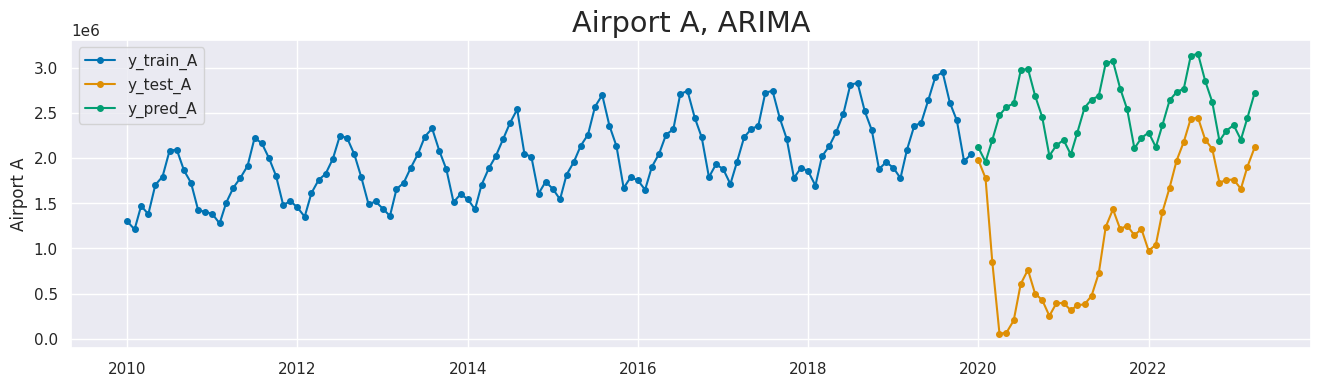

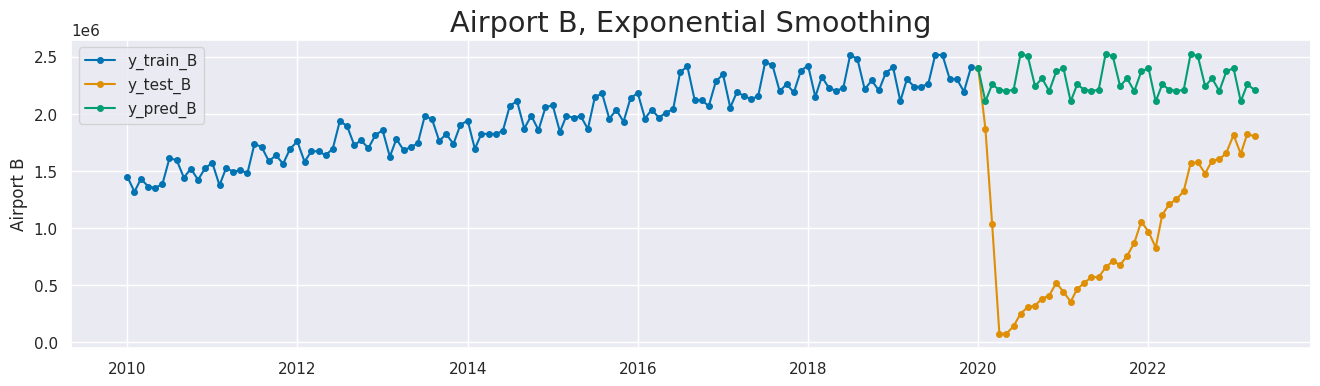

In [16]:
# plotting ARIMA result of Airport A
plot_series(before_covid['Airport A'], after_covid['Airport A'], covid_y_pred_arima['Airport A'],
            labels=['y_train_A', 'y_test_A', 'y_pred_A'], title='Airport A, ARIMA')

# plotting Exponential Smoothing result of Airport B
plot_series(before_covid['Airport B'], after_covid['Airport B'], covid_y_pred_exp['Airport B'],
            labels=['y_train_B', 'y_test_B', 'y_pred_B'], title='Airport B, Exponential Smoothing')

In [17]:
# Calculating MAPE of ARIMA prediction for Airport A and MAPE of Exponential Smoothing prediction for Airport B
print('Airport A, ARIMA: %.4f' % mape(after_covid['Airport A'], covid_y_pred_arima['Airport A']))
print('Airport B, Exponential Smoothing: %.4f' % mape(after_covid['Airport B'], covid_y_pred_exp['Airport B']))

Airport A, ARIMA: 4.0908
Airport B, Exponential Smoothing: 3.7905


# Interpretating results

We see that the new predictions have a big gap (409.08% MAPE for Airport A, 379.05% MAPE for Airport B) compared to the actual COVID-19 passenger numbers.

Why did the MAPEs have increased significantly? (Airport A: 2.54% -> 409.08%)
(Airport B: 0.99% -> 379.05%)

This is because the statistic model works on top of an assumption that the future predictions are based on the historical patterns.

Some events where the past pattern no longer applies, in this example, COVID-19, the statistic model cannot perform the accurate predictions.

# Group Discussion

*In case where the statistical forecasting cannot be done, what would be alternatives to perform forecasting?*